Shape: (832, 9)

Missing values:
 Date                0
Product_Name        0
Region              0
Price               0
Cost                0
Competitor_Price    0
Promo               0
Holiday_Flag        0
Units_Sold          0
dtype: int64

Data types:
 Date                 object
Product_Name         object
Region               object
Price               float64
Cost                float64
Competitor_Price    float64
Promo                 int64
Holiday_Flag          int64
Units_Sold            int64
dtype: object


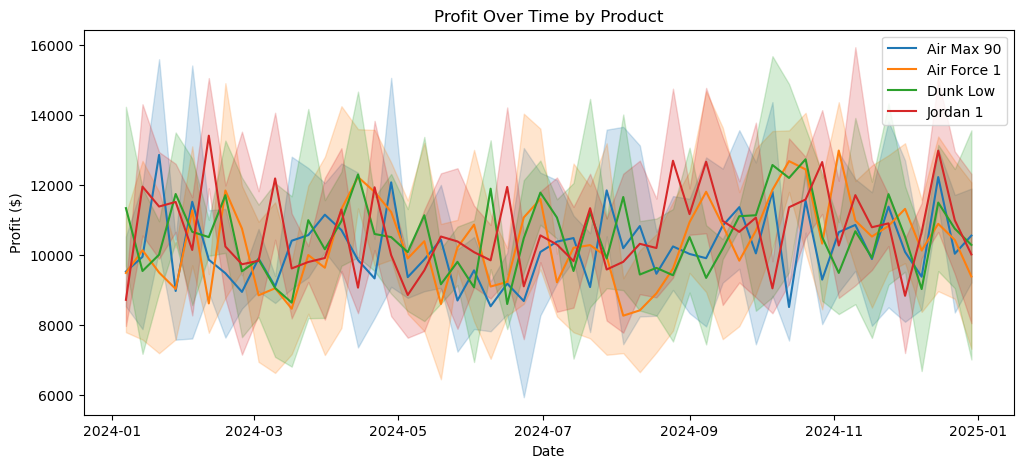

RMSE: 30.624170896756905
R² Score: -0.07952782127050839
Optimal Price: $120.00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize

df = pd.read_csv("nike_sneakers_sales.csv")
df.head()

print("Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)

df['Date'] = pd.to_datetime(df['Date'])

df['Revenue'] = df['Price'] * df['Units_Sold']
df['Profit'] = (df['Price'] - df['Cost']) * df['Units_Sold']

plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='Date', y='Profit', hue='Product_Name')
plt.title("Profit Over Time by Product")
plt.xlabel("Date")
plt.ylabel("Profit ($)")
plt.legend()
plt.show()

df['Promo_Flag'] = df['Promo'].apply(lambda x: 1 if x else 0)
df['Holiday_Flag'] = df['Holiday_Flag'].astype(int)

df['Price_Diff'] = df['Price'] - df['Competitor_Price']

df = pd.get_dummies(df, columns=['Product_Name', 'Region'], drop_first=True)

features = [col for col in df.columns if col not in ['Date', 'Units_Sold', 'Revenue', 'Profit']]
X = df[features]
y = df['Units_Sold']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

cost = 80  #A guess

def profit_objective(price):
    price = price[0]
    
    temp = X_test.copy()
    
    temp['Price'] = price
    
    temp['Price_Diff'] = price - temp['Competitor_Price']
    
    # Predict sales
    predicted_sales = model.predict(temp)
    
    cost = 80  
    
    total_profit = (price - cost) * predicted_sales.sum()
    
    return -total_profit  

result = minimize(profit_objective, x0=[120], bounds=[(90, 160)])
optimal_price = result.x[0]
print(f"Optimal Price: ${optimal_price:.2f}")